In [1]:
import cv2
import joblib
import os
from matplotlib import pyplot as plt
from src.utils import *
import pickle # alternative to joblib 
import json
from sklearn.metrics import classification_report
import random

In [2]:
print(os.path.exists(r"src\checkpoint\rf_best_model.pkl"))

True


In [3]:
import os
import pickle
import joblib
import json

# Load the model
model_path = "src/checkpoint/rf_best_model.pkl"
try:
    with open(model_path, "rb") as f:
        model = pickle.load(f)
except:
    model = joblib.load(model_path)

# Load the parameters
params_path = "src/checkpoint/rf_params.json"
with open(params_path, "r") as f:
    params = json.load(f)

IMAGE_SIZE = params["img_size"]
BIN_SIZE = params["bin"]
print(f"\nIMAGE SIZE: {IMAGE_SIZE} \nBIN SIZE: {BIN_SIZE}")



IMAGE SIZE: 128 
BIN SIZE: 8


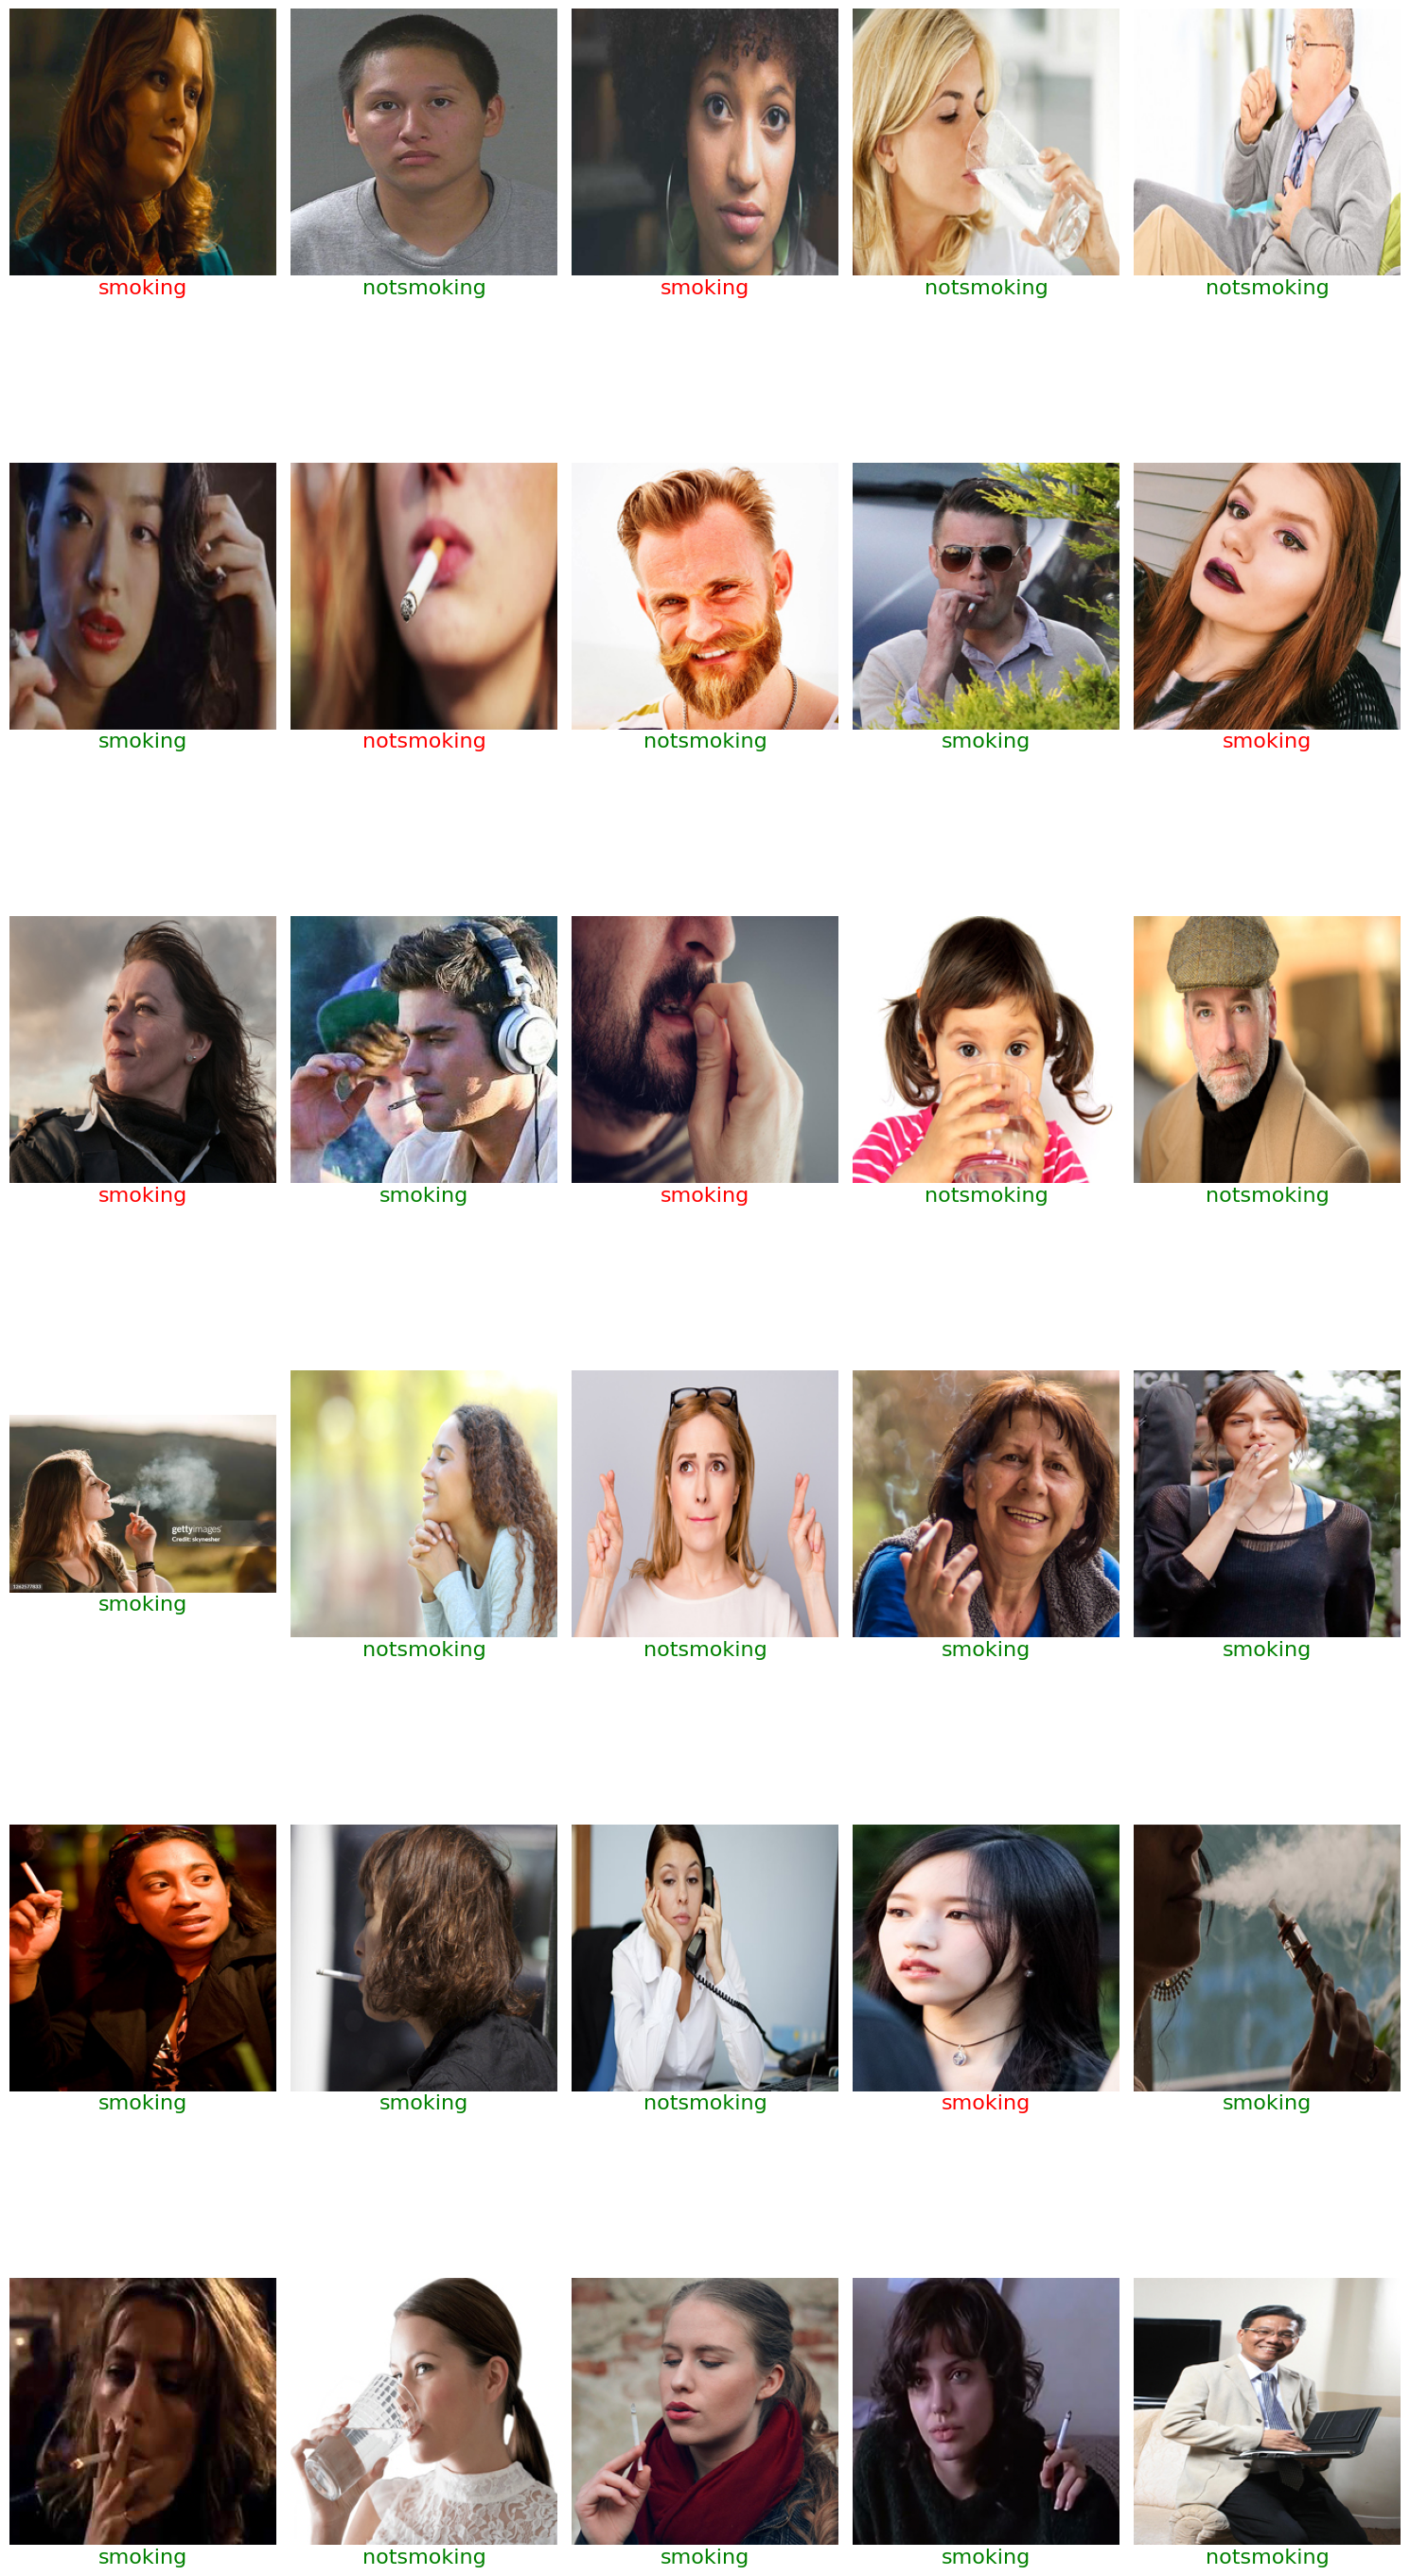

gt:     [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]
preds:  [1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]
              precision    recall  f1-score   support

  notsmoking       0.92      0.65      0.76        17
     smoking       0.67      0.92      0.77        13

    accuracy                           0.77        30
   macro avg       0.79      0.79      0.77        30
weighted avg       0.81      0.77      0.77        30



In [4]:
test_path = "data/test/"
image_files = os.listdir(test_path)

label_names = ['notsmoking', 'smoking']
gt = []
preds = []
# number of wanted images
num_images = 30
if num_images > len(image_files):
    num_images = len(image_files)

# number of images per row
images_per_row = 5 if num_images > 5 else num_images//2
# calc number of rows
num_rows = (num_images // images_per_row) + (1 if num_images % images_per_row != 0 else 0)

# create a grid of images
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 5 * num_rows))

# shuffle images
random.seed(42) 
random.shuffle(image_files)
# iterate over all images
for i, image_name in enumerate(image_files[:num_images]):
    # create gt
    if image_name.startswith("smoking"):
        gt.append(1)
    elif image_name.startswith("notsmoking"):
        gt.append(0)
    
    
    # read image
    image_path = os.path.join(test_path, image_name)
    origin_image = cv2.imread(image_path)
    origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)  # Đổi màu từ BGR sang RGB

    # feature extraction and predict
    feature_image = cv2.resize(origin_image, (IMAGE_SIZE, IMAGE_SIZE))
    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2HSV)
    feature = calc_hist(feature_image, BIN_SIZE)

    pred = model.predict([feature])[0]
    preds.append(pred)
    label = label_names[pred]



    # calculate row and col index
    row = i // images_per_row
    col = i % images_per_row

    # plot image
    axes[row, col].imshow(origin_image)
    axes[row, col].axis('off')  # Tắt hiển thị trục

    # add label
    if pred == gt[-1]:
        axes[row, col].text(0.5, -0.01, label, ha='center', va='top', fontsize=16, color='green', transform=axes[row, col].transAxes)
    else:
        axes[row, col].text(0.5, -0.01, label, ha='center', va='top', fontsize=16, color='red', transform=axes[row, col].transAxes)

# remove empty subplots
for i in range(num_images, num_rows * images_per_row):
    row = i // images_per_row
    col = i % images_per_row
    axes[row, col].axis('off')

plt.tight_layout()  # Điều chỉnh khoảng cách giữa các ảnh
plt.show()

print("gt:    ", gt)
print("preds: ", preds)
print(classification_report(gt, preds, target_names=label_names))
